In [107]:
%pylab inline
import homer
import glob
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
root_dir = '/data/'

In [5]:
wel_files = homer.build_weighted_edgelist_db(
    tw_file_globstring=root_dir + 'posts*', 
    intermediate_files_globstring=root_dir+'/parsing/int_*.csv',
    output_files_globstring=root_dir+'wel_*.csv',
    languages=['en'],
    dates=[20150616, 20150617, 20150618, 20150619, 20150620, 20150621, 20150622, 20150623, 20160624],
    threshold=10,
    hashtags_only=False
    )

[########################################] | 100% Completed | 34min 10.9s
[########################################] | 100% Completed |  2min  7.2s


In [105]:
wel_files = glob.glob(root_dir+'wel*.csv')
wel_files

['/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20150616.csv',
 '/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20150617.csv',
 '/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20150618.csv',
 '/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20150619.csv',
 '/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20150620.csv',
 '/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20150621.csv',
 '/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20150622.csv',
 '/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20150623.csv',
 '/Users/houghton/Desktop/tw/hashtags_only/hashtag_wel_20160624.csv']

In [4]:
assert len(wel_files) == len([20150616, 20150617, 20150618, 20150619, 20150620, 20150621, 20150622, 20150623, 20160624])

In [5]:
cluster_files = homer.build_cluster_db(
    weighted_edge_list_files=sorted(wel_files)[:-1],
    intermediate_files_directory=root_dir+'cos_working',
    output_files_directory=root_dir+'cos_output',
    dates=[20150616, 20150617, 20150618, 20150619, 20150620, 20150621, 20150622, 20150623],
    thresholds=[2]
)

In [11]:
cluster_files_df = pd.DataFrame(cluster_files)
cluster_files_df['k'] = cluster_files_df['k'].apply(int)
cluster_files_df.head()

date                                               file   k  threshold
0  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  10          2
1  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  11          2
2  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  12          2
3  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  13          2
4  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  14          2

In [119]:
inter_day_cluster_files = homer.clusterer.build_transition_cluster_db(
    weighted_edge_list_files=sorted(wel_files)[:-1],
    intermediate_files_directory=root_dir+'cos_working_tr',
    output_files_directory=root_dir+'cos_output_tr',
    dates=[20150616, 20150617, 20150618, 20150619, 20150620, 20150621, 20150622, 20150623],
    thresholds=[2]
)

In [126]:
inter_day_cluster_files_df = pd.DataFrame(inter_day_cluster_files)
inter_day_cluster_files_df['k'] = inter_day_cluster_files_df['k'].apply(int)
inter_day_cluster_files_df.head()

date                                               file   k  \
0  20150616_20150617  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  10   
1  20150616_20150617  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  11   
2  20150616_20150617  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  12   
3  20150616_20150617  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  13   
4  20150616_20150617  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  14   

   threshold  
0          2  
1          2  
2          2  
3          2  
4          2

In [ ]:
#find children
children_filenames = homer.relate.build_children_db(cluster_files_df, 
                                                    root_dir+'children_*.csv')



In [43]:
# to recover the cluster files:

output_files_directory='/Users/houghton/Desktop/tw/hashtags_only/cos_output'
collector = []
for date_dir in glob.glob(output_files_directory+'/*'):
    date = date_dir.split('/')[-1]
    for th_dir in glob.glob(date_dir+'/*'):
        th = th_dir.split('/')[-1]
        for cluster_file in glob.glob(th_dir+'/*.csv'):
            k = int(cluster_file.split('/')[-1].split('_')[0])
            collector.append({'date':date, 'threshold':th, 'k':k, 'file':cluster_file})
            
cluster_files_df = pd.DataFrame(collector)
cluster_files_df.head()

date                                               file   k threshold
0  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  10         2
1  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  11         2
2  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  12         2
3  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  13         2
4  20150616  /Users/houghton/Desktop/tw/hashtags_only/cos_o...  14         2

In [44]:
Cluster = homer.tree.Cluster

In [45]:
#populate tree with nodes
root = Cluster('__root__')
for _, row in cluster_files_df.iterrows():
    clusters = pd.read_csv(row['file'], header=None, names=['ID', 'set'])
    for _, cluster in clusters.iterrows():
        new = Cluster(contents=cluster['ID'],
                  k=row['k'],
                  w=row['threshold'],
                  date=row['date'])
        root.insert(new)
        if row['k'] == 3:
            root.k_children.append(new)


In [47]:
def find_k_children(parent_file, child_file):
    parents = pd.read_csv(parent_file, header=None, names=['ID', 'set'], index_col=['ID'])
    parents['set'] = parents['set'].apply(lambda x: set(x.split(' ')))
    child_candidates = pd.read_csv(child_file, header=None, names=['ID', 'set'], index_col=['ID'])
    child_candidates['set'] = child_candidates['set'].apply(lambda x: set(x.split(' ')))

    collector = []
    for parent_id, parent in parents.iterrows():
        children = [child_id for child_id, child in child_candidates.iterrows() if
                    child['set'].issubset(parent['set'])]
        if len(children) > 0:
            collector.append({'ID': parent_id,
                              'children': children})

    return collector


def build_day(cluster_files_df):
    current_group = cluster_files_df.sort(columns='k').reset_index(drop=True)
    collector = []
    for ia, ib in zip(current_group.index[:-1], current_group.index[1:]):
        collector = collector + find_k_children(current_group['file'].loc[ia],
                                                current_group['file'].loc[ib])
    return collector
    
    

In [48]:
for (date, threshold), group in cluster_files_df.groupby(by=['date', 'threshold']):
    print(date, threshold)
    for element in build_day(group):
        print('.', end='')
        node = root.find(element['ID'])
        for child in element['children']:
            node.k_children.append(root.find(child))

20150616 2


/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
# iterate through files, starting with the highest k, working to lower k
# for each cluster in the file, find its cluster in the tree, and poll for members,
# add leaves for missing members

In [57]:
# add leaves

for _, row in cluster_files_df.sort('k', ascending=False).iterrows():
    print(row)
    clusters = pd.read_csv(row['file'], header=None, names=['ID', 'set'])
    for _, cluster in clusters.iterrows():
        node = root.find(cluster['ID'])
        present_in_children = [m.contents for m in node.get_k_members()]
        words = cluster['set'].split(' ')
        for leaf_word in list(set(words) - set(present_in_children)):
                leaf = root.find(leaf_word)
                if leaf is None:
                    leaf = Cluster(leaf_word, is_leaf=True)
                    root.insert(leaf)
                node.k_children.append(leaf)


/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


date                                                  20150618
file         /Users/houghton/Desktop/tw/hashtags_only/cos_o...
k                                                           18
threshold                                                    2
Name: 37, dtype: object
date                                                  20150621
file         /Users/houghton/Desktop/tw/hashtags_only/cos_o...
k                                                           18
threshold                                                    2
Name: 85, dtype: object
date                                                  20150619
file         /Users/houghton/Desktop/tw/hashtags_only/cos_o...
k                                                           18
threshold                                                    2
Name: 53, dtype: object
date                                                  20150620
file         /Users/houghton/Desktop/tw/hashtags_only/cos_o...
k                                             

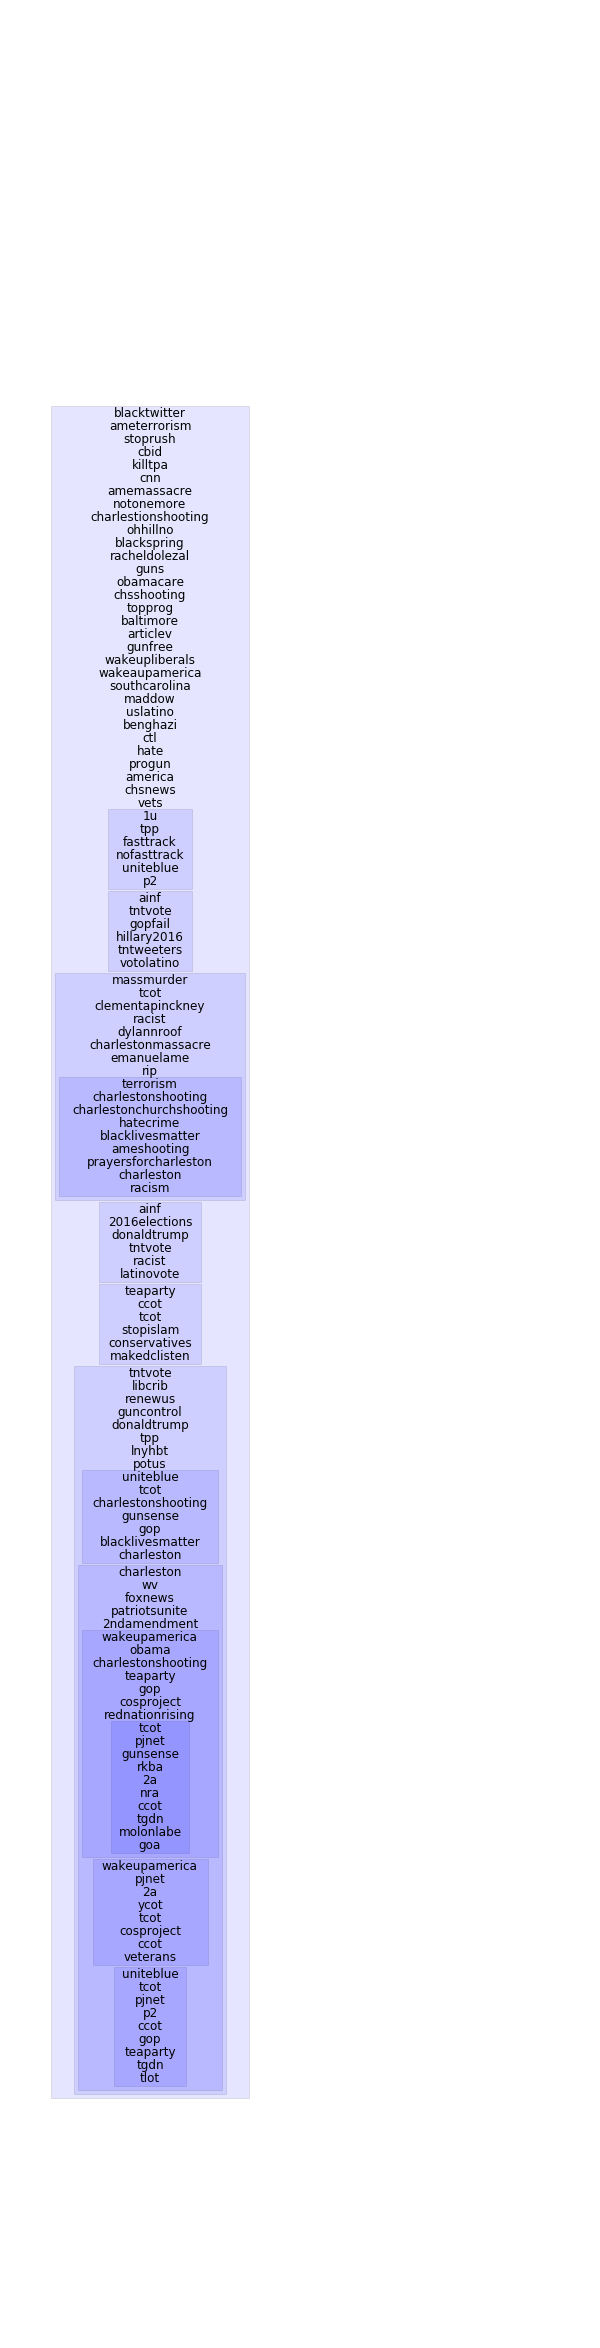

In [160]:
a = root.find('__20150618_5_2_27')
fig = plt.figure(figsize=(10,40))
ax = fig.gca()

a.draw(ax, center=150, bottom=250)

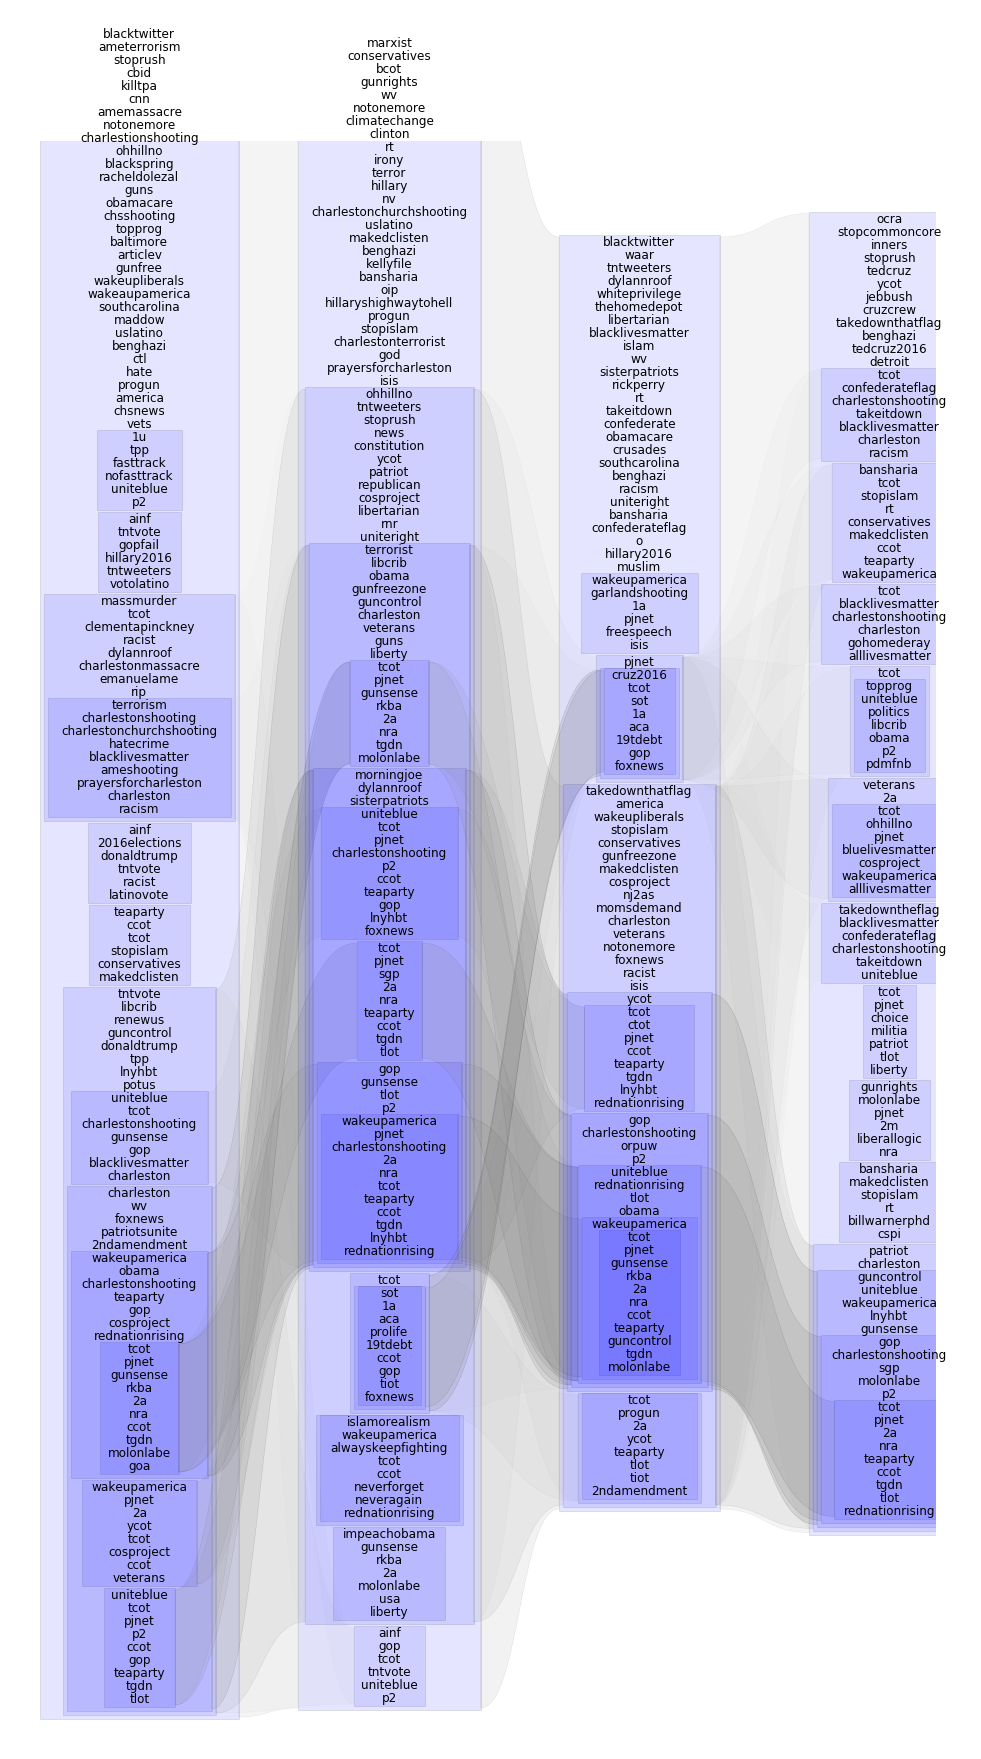

In [186]:
homer.tree.draw_series(a, 3, spacing=250)

In [128]:
daily_clusters = dask.dataframe.read_csv(list(cluster_files_df['file']), header=None, names=['ID', 'set']).compute()

In [151]:
daily_clusters['k'] = daily_clusters['ID'].apply(lambda x: int(x.split('_')[-3]))
daily_clusters['threshold'] = daily_clusters['ID'].apply(lambda x: int(x.split('_')[-2]))
daily_clusters['Date'] = daily_clusters['ID'].apply(lambda x: int(x.split('_')[-4]))

In [152]:
daily_clusters.head()

ID                                                set   k  \
0   __20150616_10_2_2   summer actor bobbyjohnson fun muscle sixpack ...  10   
1   __20150616_10_2_1   followpyramid autorefollow rt followback sigu...  10   
2  __20150616_10_2_22   baby turkey sex chick blond threesome lesbian...  10   
3  __20150616_10_2_12   fantasy mystery romance kindle ian1 ebooks sc...  10   
4  __20150616_10_2_28   funk dance hiphop soul chat nowplaying reggae...  10   

   threshold      Date  
0          2  20150616  
1          2  20150616  
2          2  20150616  
3          2  20150616  
4          2  20150616

In [129]:
inter_day_clusters = dask.dataframe.read_csv(list(inter_day_cluster_files_df['file']), header=None, names=['ID', 'set']).compute()

In [147]:
inter_day_clusters['k'] = inter_day_clusters['ID'].apply(lambda x: int(x.split('_')[-3]))
inter_day_clusters['threshold'] = inter_day_clusters['ID'].apply(lambda x: int(x.split('_')[-2]))
inter_day_clusters['Date_1'] = inter_day_clusters['ID'].apply(lambda x: int(x.split('_')[-5]))
inter_day_clusters['Date_2'] = inter_day_clusters['ID'].apply(lambda x: int(x.split('_')[-4]))

In [148]:
inter_day_clusters.head()

ID  \
0  __20150616_20150617_10_2_75   
1  __20150616_20150617_10_2_42   
2   __20150616_20150617_10_2_8   
3  __20150616_20150617_10_2_20   
4  __20150616_20150617_10_2_29   

                                                 set   k  threshold    Date_1  \
0   usdchf news money follow eurusd binary ff usd...  10          2  20150616   
1   mh17 paris london donetsk auspol berlin ziona...  10          2  20150616   
2   99cents bookboost mystery amwriting tw4rw byn...  10          2  20150616   
3   ｶﾊﾞｰ iphone6plus leather ｹｰｽ ファッション goldmedus...  10          2  20150616   
4   100aday f4f gainbot followme 500aday ifollowb...  10          2  20150616   

     Date_2  
0  20150617  
1  20150617  
2  20150617  
3  20150617  
4  20150617

In [178]:
transition_list = homer.transition.compute_transition_list(daily_clusters, inter_day_clusters,
                                                           '/Users/houghton/Desktop/tw/hashtags_only/transitions.csv')

[########################################] | 100% Completed |  2hr 30min 55.7s


In [179]:
transition_list.head()

C1                  C2  similarity
0  __20150616_10_2_12  __20150617_10_2_44    0.476190
1  __20150616_10_2_12  __20150617_10_2_43    0.521739
2  __20150616_10_2_12  __20150617_10_2_21    0.565217
0  __20150616_10_2_10  __20150617_10_2_18    0.857143
0   __20150616_10_2_6  __20150617_10_2_31    0.769231

In [181]:
# add connections to subsequent day clusters
for i, (c1, c2, similarity) in transition_list.iterrows():
    n1 = root.find(c1)
    n2 = root.find(c2)
    n1.tomorrow.append(n2)
    n1.p_tomorrow.append(similarity)


In [182]:
for node in homer.tree.walk_tree(root):
    node.k_parents = []

In [183]:
for node in homer.tree.walk_tree(root):
    for child in node.k_children:
        child.k_parents.append(node)
    

In [184]:
import gzip
tree_filename = '/Users/houghton/Desktop/tw/hashtags_only/tree1.json.gz'
with gzip.open(tree_filename, 'wb') as f:
        for node in homer.tree.walk_tree(root):
            f.write((node.to_json() + '\n').encode())

[__20150619_7_2_129,
 __20150619_7_2_89,
 __20150619_7_2_65,
 __20150619_7_2_33,
 uniteright,
 rnr,
 libertarian,
 cosproject,
 republican,
 patriot,
 ycot,
 constitution,
 news,
 stoprush,
 tntweeters,
 ohhillno]

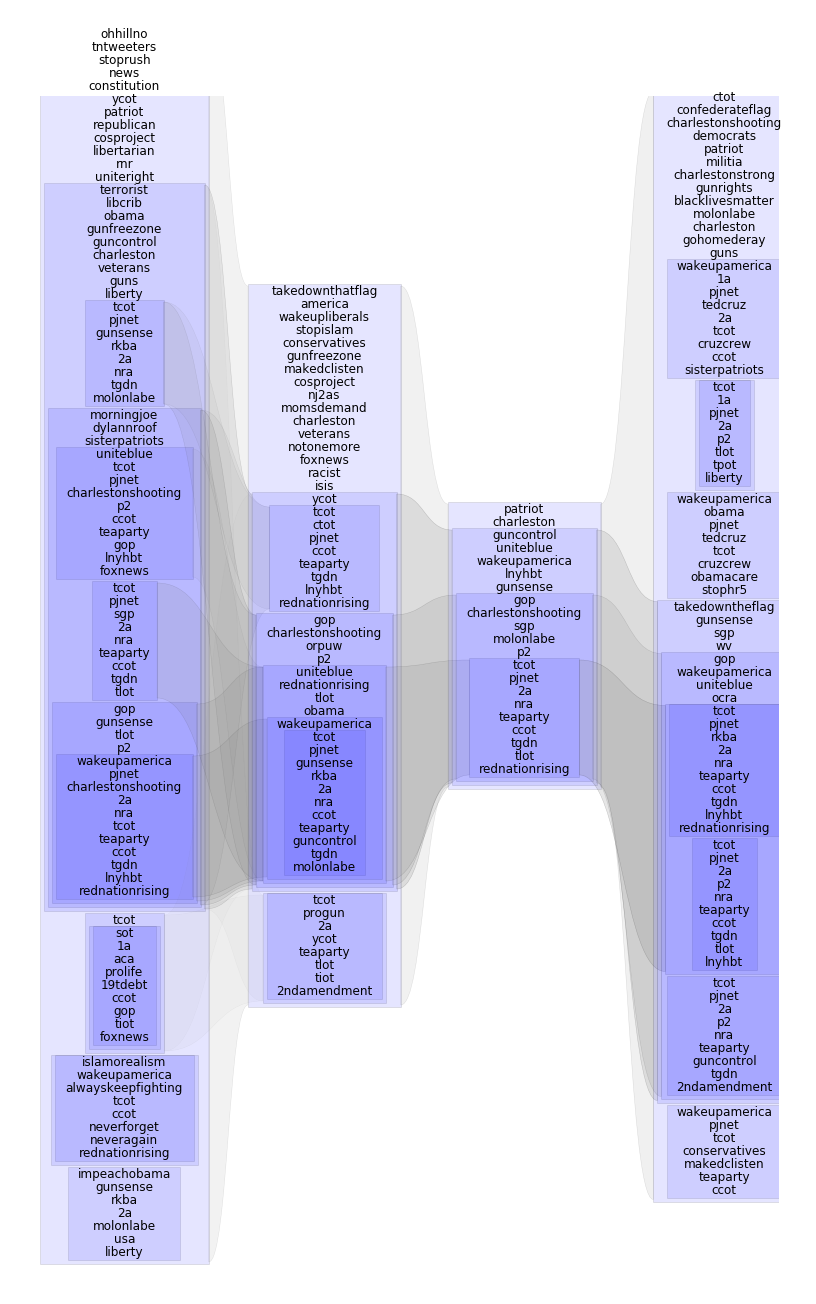

In [309]:
n = root.find('charlestonshooting')
a = n.k_parents[16].k_parents[0].k_parents[0].k_parents[0].k_parents[0]
homer.tree.draw_series(a, 3, spacing=200)
a.k_children

In [320]:
n = root.find('charlestonshooting')
a = n.k_parents[6].k_parents[0]
homer.tree.draw_series(a, 3, spacing=200)
a.k_children

KeyboardInterrupt: 

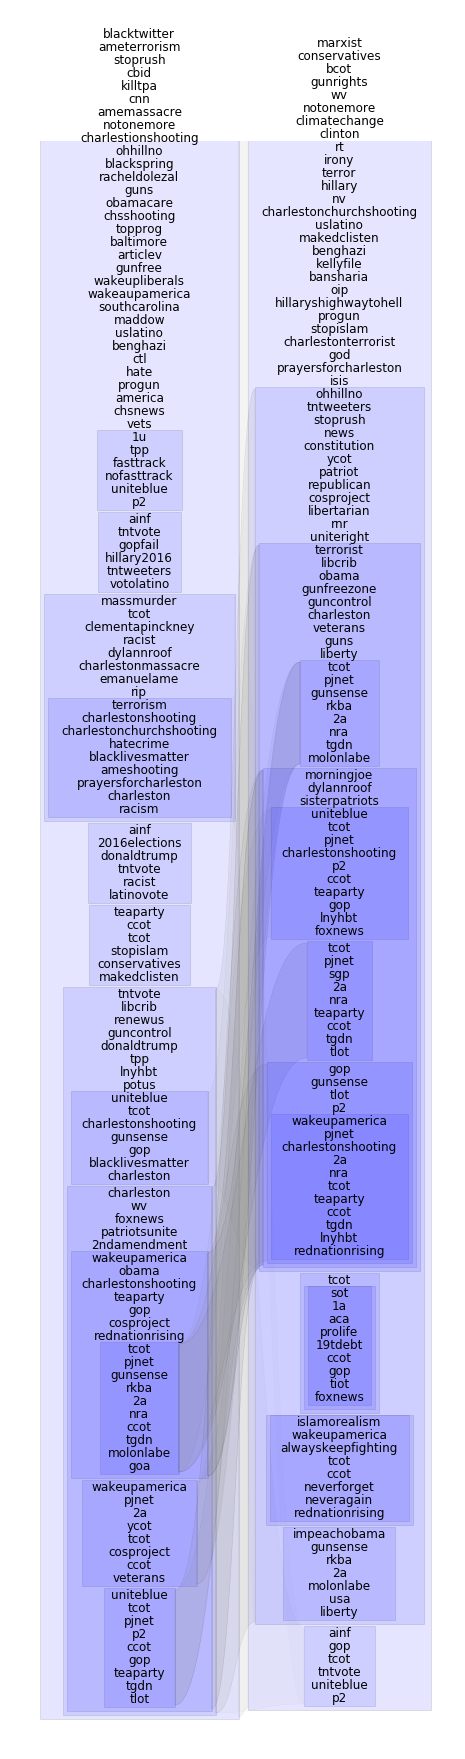

In [329]:
a = root.find('__20150618_7_2_188').k_parents[0].k_parents[0]
homer.tree.draw_series(a, 1, spacing=200)

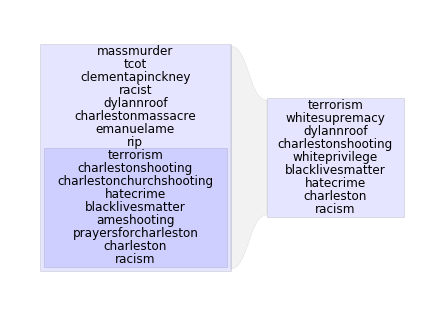

In [330]:
a = root.find('__20150618_7_2_188').k_parents[0]
homer.tree.draw_series(a, 1, spacing=200)

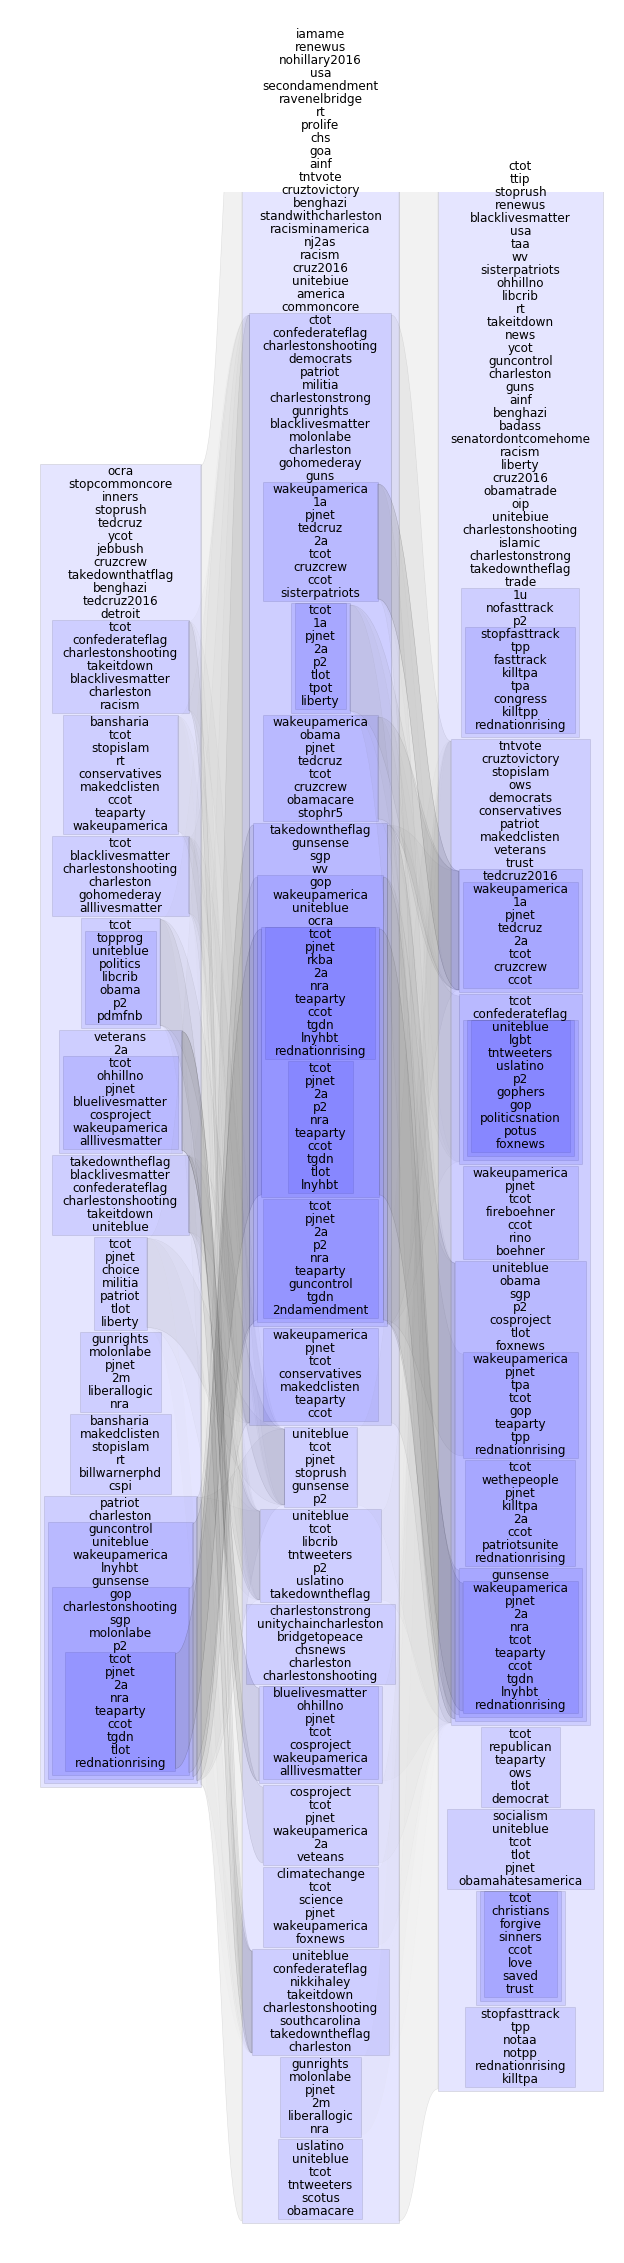

In [336]:
a = root.find('__20150621_6_2_360').k_parents[0]
homer.tree.draw_series(a, 2, spacing=200)

In [337]:
n = root.find('takeitdown')
for p in n.k_parents:
    print(p, len(list(p.k_parents[0].get_k_members())))

__20150618_4_2_0 9369
__20150619_4_2_0 9598
__20150620_5_2_3 5190
__20150620_5_2_574 5190
__20150621_4_2_652 9083
__20150621_6_2_360 107
__20150621_6_2_379 107
__20150622_6_2_357 178
__20150623_5_2_8 5669


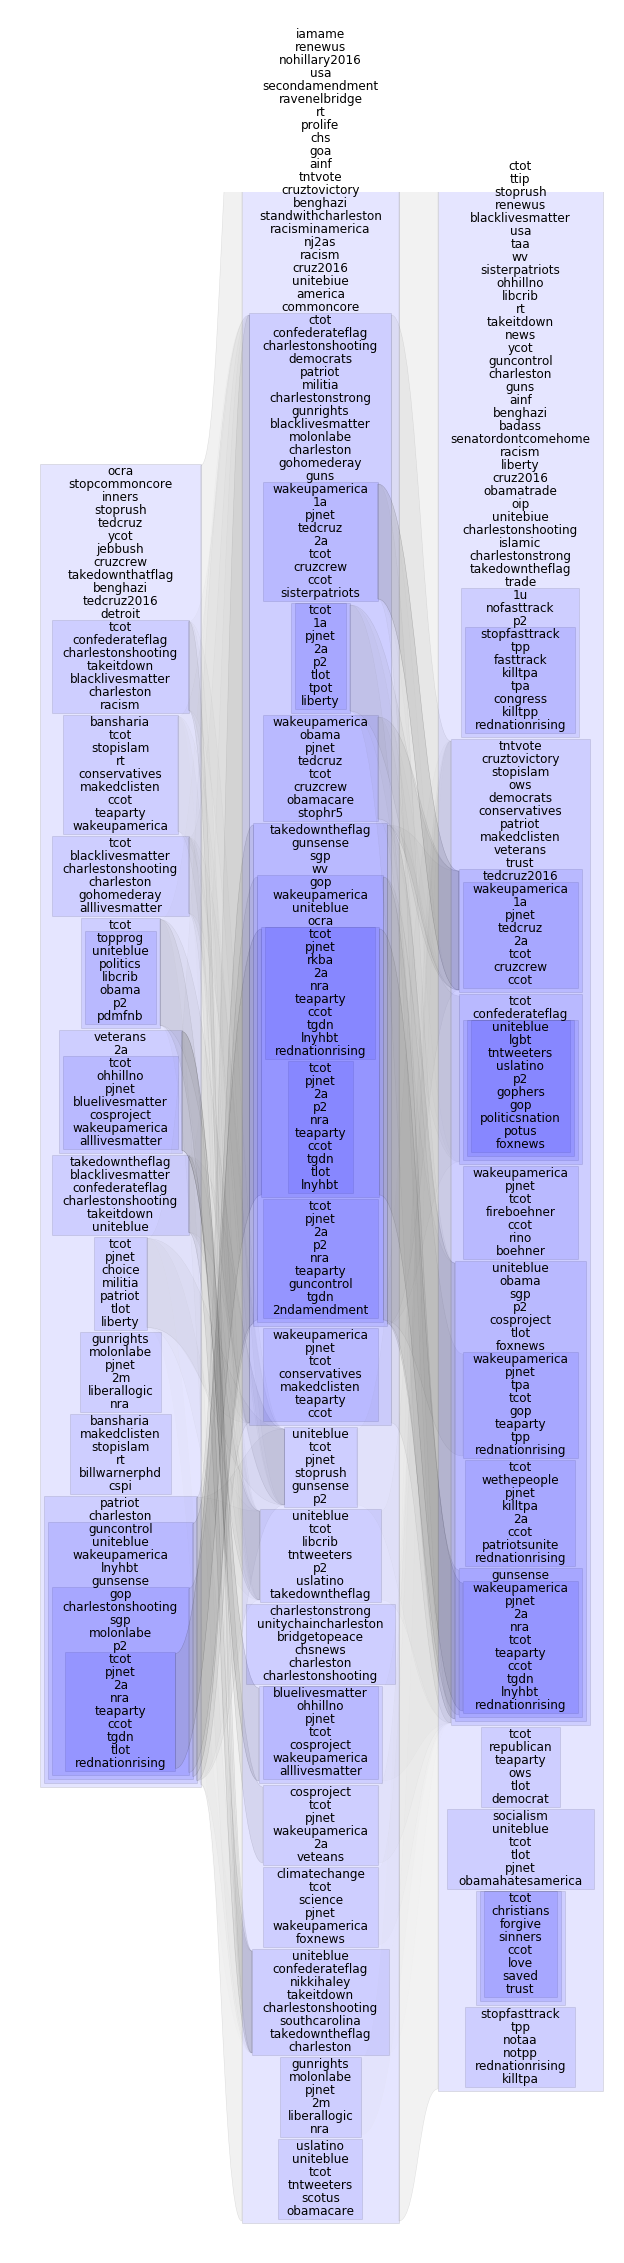

In [339]:
a = root.find('__20150621_6_2_360').k_parents[0]
homer.tree.draw_series(a, 2, spacing=200)

In [356]:
n = root.find('charleston')
for p in n.k_parents:
    print(p, end='\t')
    for i in range(10):
        try:
            print(len(list(p.get_k_members())), end='\t')
            p = p.k_parents[0]
        except:
            print('')
            break

__20150616_4_2_0	5845	10022	129227	
__20150617_5_2_0	3383	5786	9906	129227	
__20150618_3_2_764	4	129227	
__20150618_4_2_483	5	9369	129227	
__20150618_4_2_488	5	9369	129227	
__20150618_4_2_613	6	9369	129227	
__20150618_5_2_0	3118	5298	9369	129227	
__20150618_5_2_399	6	6	9369	129227	
__20150618_5_2_527	6	6	9369	129227	
__20150618_5_2_584	6	5298	9369	129227	
__20150618_5_2_587	6	5298	9369	129227	
__20150618_7_2_188	10	18	135	5298	9369	129227	
__20150618_7_2_207	8	58	135	5298	9369	129227	
__20150618_7_2_61	42	58	135	5298	9369	129227	
__20150619_3_2_910	4	129227	
__20150619_3_2_912	4	129227	
__20150619_3_2_913	4	129227	
__20150619_5_2_290	6	5897	9598	129227	
__20150619_5_2_492	6	5897	9598	129227	
__20150619_5_2_573	6	5897	9598	129227	
__20150619_6_2_345	10	23	5897	9598	129227	
__20150619_6_2_355	7	23	5897	9598	129227	
__20150619_7_2_33	58	98	132	5897	9598	129227	
__20150620_3_2_705	4	129227	
__20150620_3_2_711	4	129227	
__20150620_4_2_562	5	8944	129227	
__20150620_6_2_3	56	99	5190	8944	1292

In [357]:
n = root.find('charlestonshooting')
for p in n.k_parents:
    print(p, end='\t')
    for i in range(10):
        try:
            print(len(list(p.get_k_members())), end='\t')
            p = p.k_parents[0]
        except:
            print('')
            break

__20150618_3_2_1242	4	129227	
__20150618_3_2_279	6	129227	
__20150618_3_2_678	4	129227	
__20150618_3_2_766	4	129227	
__20150618_4_2_483	5	9369	129227	
__20150618_4_2_488	5	9369	129227	
__20150618_4_2_613	6	9369	129227	
__20150618_4_2_851	5	9369	129227	
__20150618_4_2_882	5	9369	129227	
__20150618_5_2_312	6	5298	9369	129227	
__20150618_5_2_459	6	5298	9369	129227	
__20150618_5_2_584	6	5298	9369	129227	
__20150618_5_2_8	45	5298	9369	129227	
__20150618_7_2_188	10	18	135	5298	9369	129227	
__20150618_7_2_207	8	58	135	5298	9369	129227	
__20150618_8_2_70	18	42	58	135	5298	9369	129227	
__20150619_10_2_45	12	16	40	58	98	132	5897	9598	129227	
__20150619_3_2_591	4	129227	
__20150619_3_2_615	4	129227	
__20150619_3_2_863	4	129227	
__20150619_3_2_914	4	129227	
__20150619_3_2_915	4	129227	
__20150619_4_2_48	12	9598	129227	
__20150619_4_2_488	5	9598	129227	
__20150619_4_2_587	5	9598	129227	
__20150619_5_2_0	3453	5897	9598	129227	
__20150619_5_2_293	6	6	9598	129227	
__20150619_5_2_487	6	5897	9598	129227

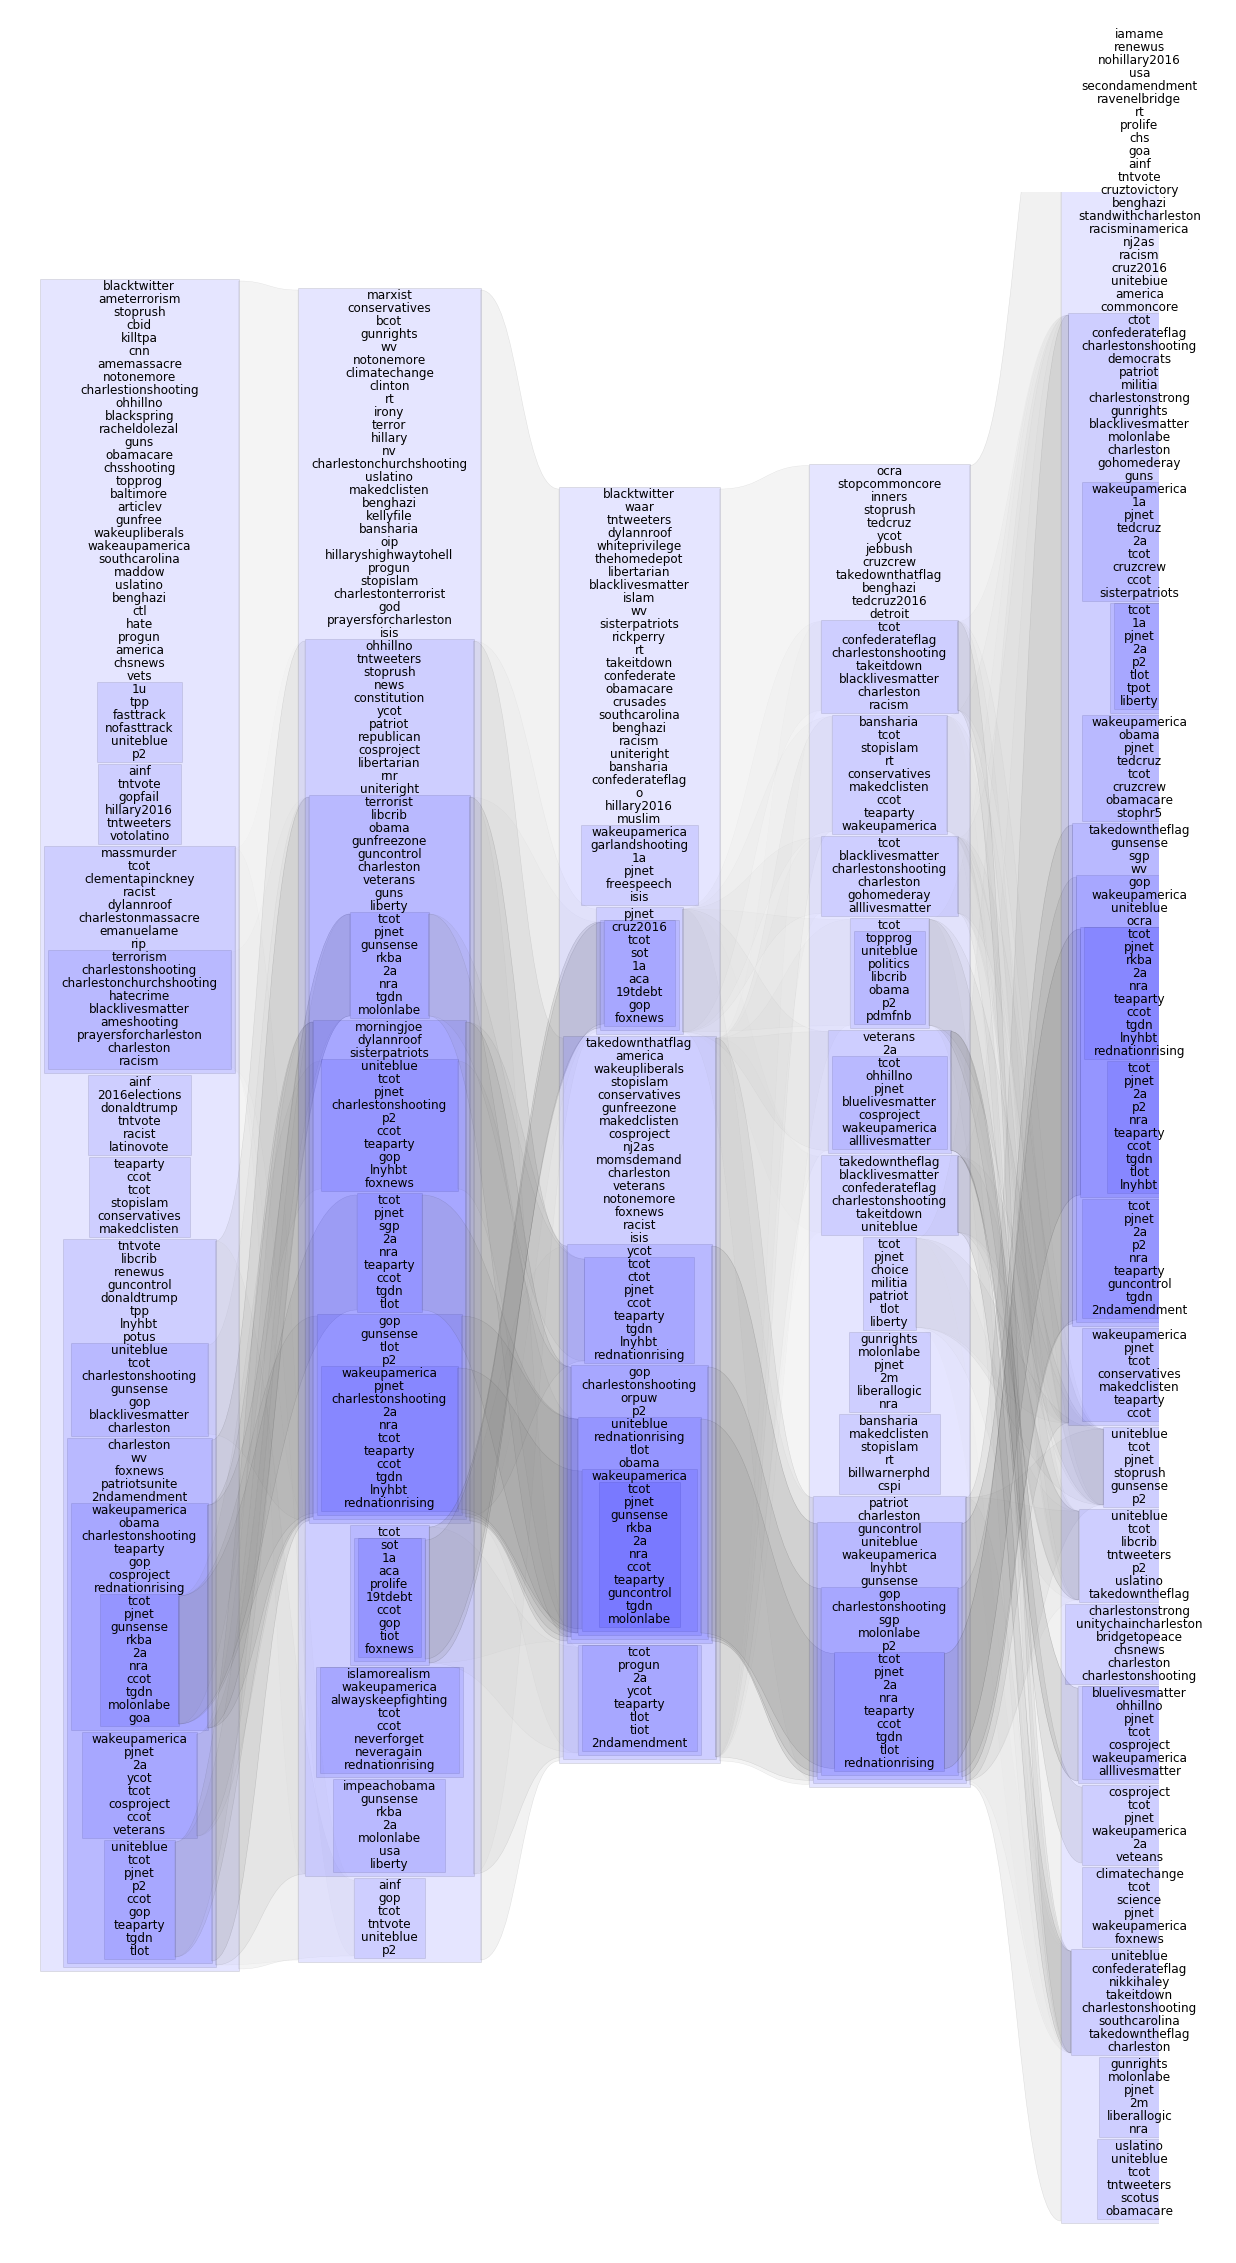

In [361]:
a = root.find('__20150618_8_2_70').k_parents[0].k_parents[0].k_parents[0]
homer.tree.draw_series(a, 4, spacing=250)

In [ ]:
n = root.find('charlestonshooting')
for p in n.k_parents:
    print(p, end='\t')
    for i in range(10):
        try:
            print(len(list(p.get_k_members())), end='\t')
            p = p.k_parents[0]
        except:
            print('')
            break

In [364]:
n = root.find('hillary2016')
for p in n.k_parents:
    print(p, end='\t')
    for i in range(10):
        try:
            print(len(list(p.get_k_members())), end='\t')
            p = p.k_parents[0]
        except:
            print('')
            break

__20150616_3_2_1123	4	129227	
__20150616_6_2_30	63	3191	5845	10022	129227	
__20150617_5_2_39	10	5786	9906	129227	
__20150617_6_2_225	7	155	5786	9906	129227	
__20150617_7_2_206	8	69	155	5786	9906	129227	
__20150618_6_2_300	7	135	5298	9369	129227	
__20150619_3_2_0	9598	129227	
__20150620_5_2_3	99	5190	8944	129227	
__20150621_5_2_61	13	5195	9083	129227	
__20150622_3_2_1030	4	129227	
__20150622_3_2_1031	4	129227	
__20150622_4_2_0	5741	9884	129227	
__20150623_3_2_0	9697	129227	
__20150623_3_2_1159	4	129227	


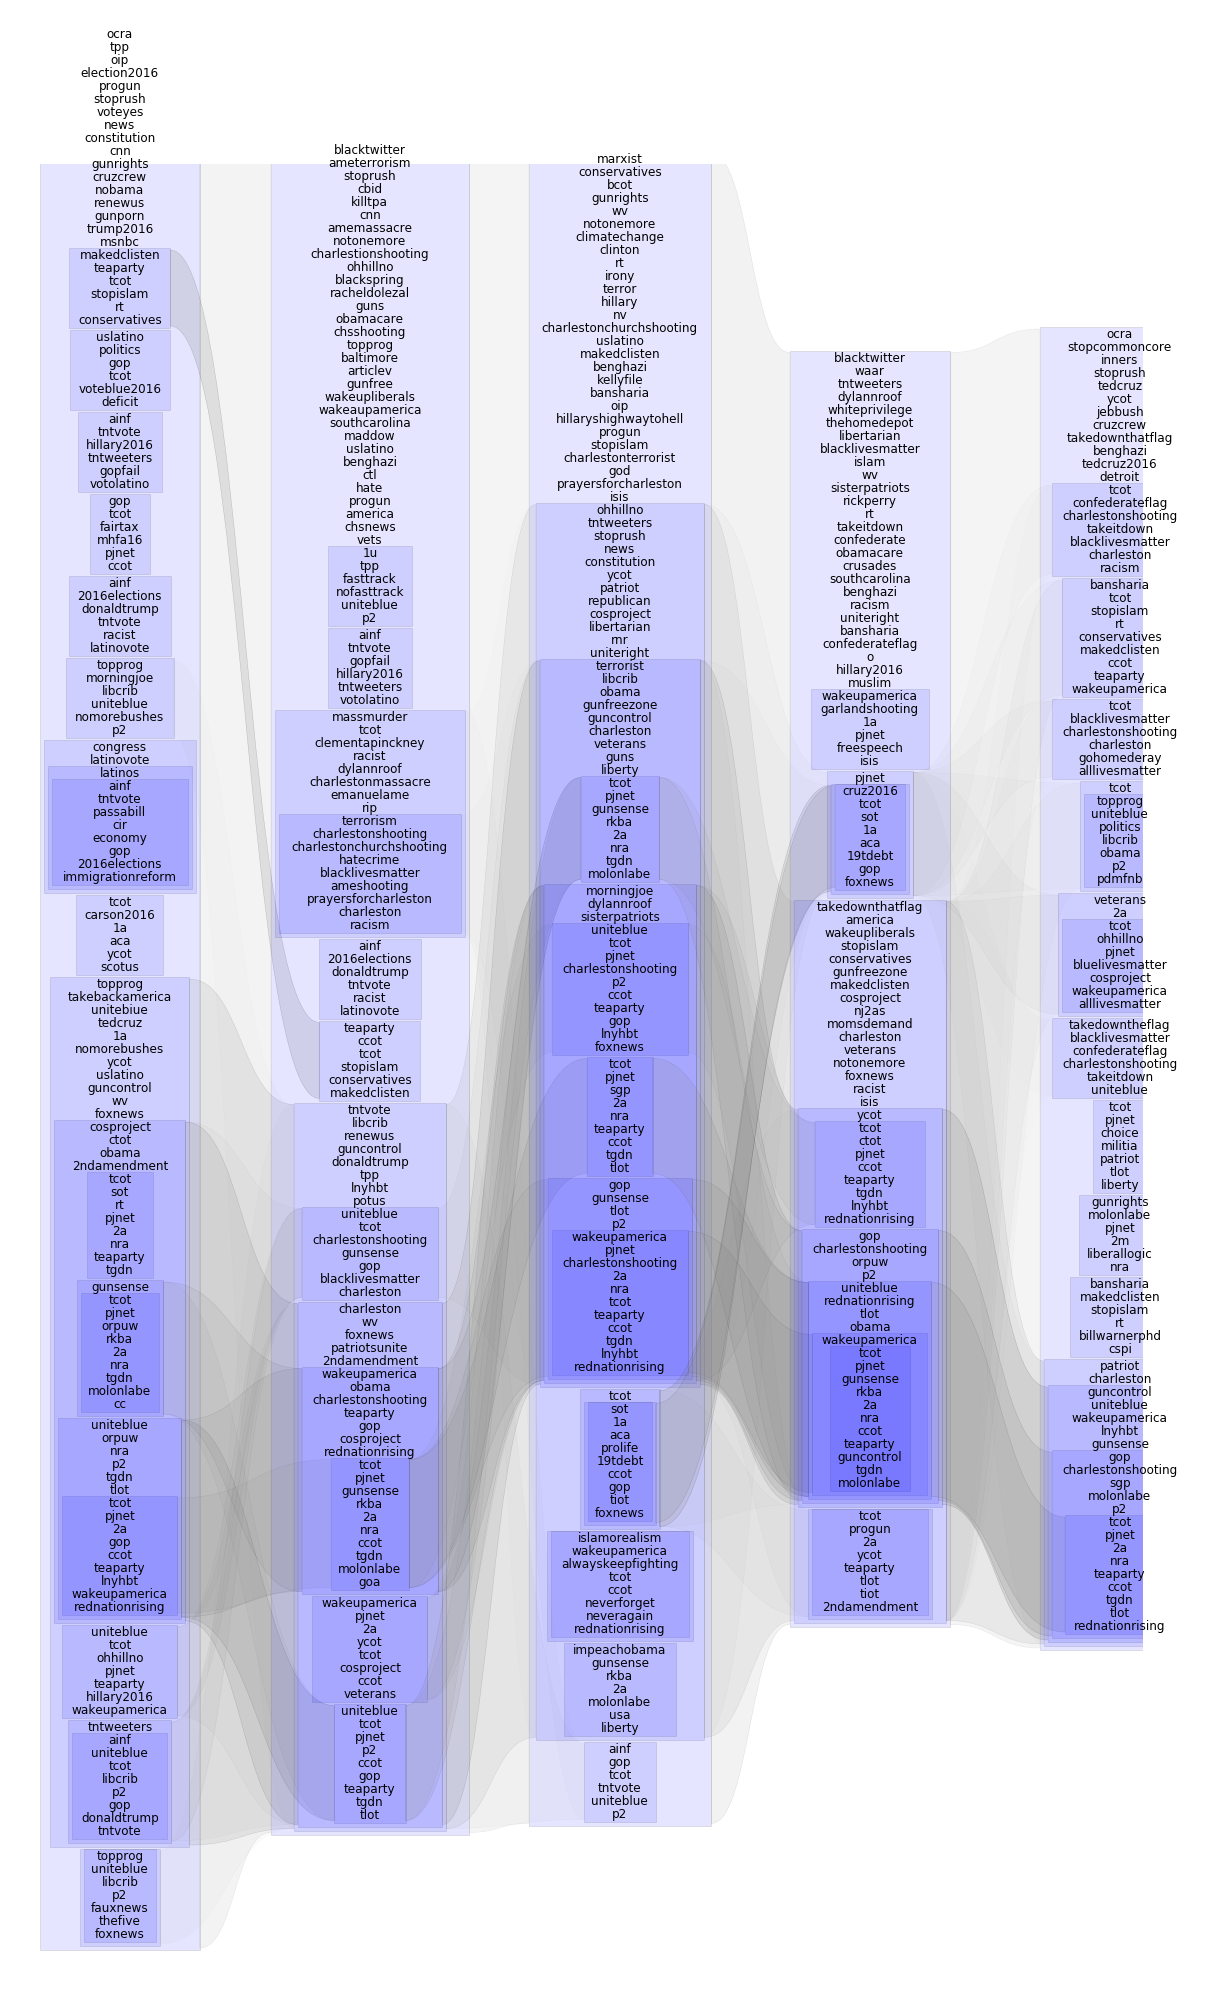

In [365]:
a = root.find('__20150617_7_2_206').k_parents[0].k_parents[0]
homer.tree.draw_series(a, 4, spacing=250)